# CityBike Wien Datensetanalyse für die Jahre 2016 und 2017

== Inhalt und Struktur dieses Notebooks 



<hr/>
## Datenset importieren bereinigen und transformieren

Im folgenden Abschnitt werden Fahrt- und Stationendaten eingelesen und je nach Anforderungen transformiert. 

Zuerst werden die, für die Auswertung und Visualisierung erforderlichen Bibliotheken importiert. Im gleichen Schritt werden die Fahrtdaten für beide Jahre aus CSV-Dateien gelesen.

In [1]:
%matplotlib inline
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
import json
#Warnungen seitens Jupyter sollen ignoriert werden
warnings.filterwarnings('ignore')

df2016 = pd.read_csv('CityBikeWien/2016trips.csv', error_bad_lines=False, parse_dates=['Startdatum', 'Enddatum'], 
                     delimiter=';')
df2017 = pd.read_csv('CityBikeWien/2017trips.csv', error_bad_lines=False, parse_dates=['Startdatum', 'Enddatum'], 
                     delimiter=';')

<i>Die beiden DataFrames für die Jahre 2016 und 2017 werden zusammengeführt:</i>

In [2]:
df_total = df2016.append(df2017)

<i>Bei dem neuen DataFrame muss der Index neu gesetzt werden:</i>

In [3]:
df_total = df_total.reset_index(drop=True)

<i>Eine neue Spalte für die Fahrtdauer wird hinzugefügt (Enddatum-Startdatum):</i>

In [4]:
df_total['Fahrtdauer'] =  df_total['Enddatum'] - df_total['Startdatum']
df2016['Fahrtdauer']   =  df2016['Enddatum']   - df2016['Startdatum']
df2017['Fahrtdauer']   =  df2017['Enddatum']   - df2017['Startdatum']

Der folgende Transformationsschritt beinhaltet die Löschung von Fahrten die weniger als zwei Minuten dauern und zugleich an der gleichen Station enden. 

<i>Die ungewollten Werte werden aus den Datensets herausgenommen:</i>

In [5]:
df_total_cleansed = df_total[ (df_total['Fahrtdauer'] > pd.Timedelta('120 sec')) 
                            & (df_total['Anfangsstation_ID'] != df_total['Endstation_ID'])]

df2016            = df2016[ (df2016['Fahrtdauer'] > pd.Timedelta('120 sec'))
                            & (df2016['Anfangsstation_ID'] != df2016['Endstation_ID'])]

df2017            = df2017[ (df2017['Fahrtdauer'] > pd.Timedelta('120 sec'))
                            & (df2017['Anfangsstation_ID'] != df2017['Endstation_ID'])]

<i>Die Details werden für das zusammengeführte und bereinigte DataFrame (df_total_cleansed) angezeigt</i>

In [6]:
df_total_cleansed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1897764 entries, 1 to 2080071
Data columns (total 7 columns):
Startdatum           datetime64[ns]
Enddatum             datetime64[ns]
Anfangsstation_ID    int64
Endstation_ID        int64
Fahrrad_ID           int64
Subscriber_ID        object
Fahrtdauer           timedelta64[ns]
dtypes: datetime64[ns](2), int64(3), object(1), timedelta64[ns](1)
memory usage: 115.8+ MB


<u>Das bereinigte DataFrame enthält insgesamt 1.897.764 Einträge für die Jahre 2016 und 2017 und setzt sich zum jetzigen Zeitpunkt aus sieben Spalten zusammen.</u>

<i>Erste Zeile des zusammengeführten DataFrames als Referenz:</i>

In [7]:
df_total_cleansed.head(1)

,Startdatum,Enddatum,Anfangsstation_ID,Endstation_ID,Fahrrad_ID,Subscriber_ID,Fahrtdauer
1,2016-01-01 00:13:04,2016-01-01 00:38:05,1026,1100,2539,0x04084286D0CC7FA3973C16F8306802A1,00:25:01


Zum jetzigen Zeitpunkt stehen drei bereinigte DataFrames welche die Fahrtdaten beinhalten zur Verfügung. Und zwar "<b>df2016</b>", "<b>df2017</b>" und das Produkt der beiden DataFrames: "<b>df_total_cleansed</b>"

<i></i>

<hr/>
###  Kennzahlen zu ausgewählten Dimensionen

<i>Fahrtdauer:</i>

In [8]:
df_total_cleansed['Fahrtdauer'].describe()

count                   1897764
mean     0 days 00:26:06.235559
std      0 days 00:48:40.033084
min      0 days 00:02:00.103000
25%             0 days 00:09:42
50%             0 days 00:16:22
75%             0 days 00:28:21
max             6 days 08:24:51
Name: Fahrtdauer, dtype: object

<hr/>
### Anzahl der Fahrten in den bereinigten Datensets

<i>Dimensionen der beiden DataFrames:</i>

In [9]:
df2016.shape

(972700, 7)

In [10]:
df2017.shape

(925064, 7)

<hr/>
### Anzahl der Nutzer je Jahr und Gesamtzeitraum

<i>Anzahl der registrierten Nutzer (bereinigtes Datenset) - 2016:</i>

In [11]:
df2016['Subscriber_ID'].nunique()

134256

<i>Anzahl der registrierten Nutzer (bereinigtes Datenset) - 2016:</i>

In [12]:
df2017['Subscriber_ID'].nunique()

131663

<i>Anzahl der registrierten Nutzer (unbereinigtes Datenset) - gesamter Zeitraum:</i>

In [13]:
df_total['Subscriber_ID'].nunique()

258719

<i>Anzahl der registrierten Nutzer (bereinigtes Datenset) - gesamter Zeitraum:</i>

In [14]:
df_total_cleansed['Subscriber_ID'].nunique()

227959

<i>Differenz zwischen bereinigtem und unbereinigtem Datenset in der Anzahl der Subscriber:</i>

In [15]:
df_total['Subscriber_ID'].nunique() - df_total_cleansed['Subscriber_ID'].nunique()

30760

<hr/>
### Stationsdaten einlesen

In den folgenden Zellen wird eine Datenquelle, welche die einzelnen Stationendaten beinhaltet in ein DataFrame transformiert. 

Die Datenquelle in XML-Format befindet sich unter der Web-API unter http://dynamisch.citybikewien.at/citybike_xml.php . Da Pandas eigenständig keinen XML-Import unterstützt war es zuerst nötig die Daten aus XML in JSON zu transformieren. Hierzu wurde ein öffentlich verfügbarer Dienst verwendet welcher unter der Adresse: http://www.utilities-online.info/xmltojson zu finden ist. 

Die JSON-Daten werden in einer lokalen Datei gespeichert welche mithilfe der open()-Funktion gelesen werden kann. Es folgt die Transformation des Streams in ein Python-Dictionary welches mithilfe von Pandas in ein DataFrame transformiert wird.

<i></i>

In [16]:
data_file = open('CityBikeWien/Stationendaten.json', encoding='UTF-8')  

json_dict = json.load(data_file)

stations_dataframe = pd.DataFrame(json_dict['stations']['station'])

<i>Erste Zeile als Referenz:</i>

In [17]:
stations_dataframe.head(1)

,boxes,description,free_bikes,free_boxes,id,internal_id,latitude,longitude,name,status
0,35,Ecke Lichtenfelsgasse U2 Station Rathaus,12,23,108,1026,48.210425,16.356100,Friedrich Schmidtplatz,aktiv


<i>Aus wie vielen Stationen setzt sich Citybike Wien zusammen?</i>

In [18]:
stations_dataframe['internal_id'].nunique()

120

<i>Wie viele Docks haben die Stationen insgesamt?</i>

In [19]:
stations_dataframe['boxes'] = stations_dataframe['boxes'].astype('int')

stations_dataframe['boxes'].sum()

3079

<i>Wie viele Docks hat die kleinste Station?</i>

In [20]:
stations_dataframe['boxes'].min()

10

<i>Wie viele Docks hat die größte Station?</i>

In [21]:
stations_dataframe['boxes'].max()

40

<u>Das System besteht aus 120 unterschiedlichen Docking-Stastionen welche insgesamt 3079 Docks zur Verfügung stellen. Die kleinste Station bietet zehn Docking-Plätze zur Verfügung wobei die gröte Station vierzig Stellplätze zur Verfügung stellt</u>

<hr/>
## Die ersten 10 Benutzer nach Benutzung für den gesamten Zeitraum


In der folgenden Zelle wird das DataFrame anhand der 'Subscriber_ID' gruppiert. 

Darauffolgend wird eine Aggregatfunktion (np.size) auf das gruppierte Objekt angewendet um die Anzahl der Fahrten je Subscriber zu erhalten. Somit erhält man ein Series-Objekt welches sortiert werden muss. 

Um die Handhabung zu erleichtern wird das Series-Objekt zu einem DataFrame mit einer einzigen Spalte transformiert.

In [22]:
grouped_by_subscriber_groups              = df_total.groupby('Subscriber_ID')

aggregated_by_subscriber_series           = grouped_by_subscriber_groups['Fahrrad_ID'].agg(np.size)

aggregated_sorted_by_subscriber_series    = aggregated_by_subscriber_series.sort_values(ascending=False)

aggregated_by_subscriber_dataframe        = aggregated_sorted_by_subscriber_series.to_frame('ANZAHL_FAHRTEN')

<i>Die ersten zehn Subscriber werden extrahiert und es wird eine Spalte die den Rang angibt hinzugefügt:</i>

In [23]:
aggregated_by_subscriber_dataframe_top_10         = aggregated_by_subscriber_dataframe[:10]

aggregated_by_subscriber_dataframe_top_10['RANG'] = np.arange(1,11) 

aggregated_by_subscriber_dataframe_top_10

,ANZAHL_FAHRTEN,RANG
Subscriber_ID,,
0x30EF7C4D0C1211B47ADBA3295EF47C61,1790,1
0xB9AF912E74C4F6602CF849721E28B621,1400,2
0xAC44D643FD2F8AE0CCD64B35A269DCC1,1297,3
0x30F9A85D6ADB8CFA380C4EA7D77C574E,1281,4
0xCA316F5E99321FD79D33C3CAB1000DA5,1193,5
0xE88FAEE35C9817B6BD91961D8DD186E0,1028,6
0x62B4268B5D5AB0FD8B0FDC93D79498DD,1025,7
0x24384492DBD8ACA63F4C29FC8BC3B36A,1011,8
0xD372854C5186AB811AEE55325547CC85,1009,9


<u>Es ist zu erkennen, dass es Nutzer gibt welche das System ausgiebig nutzen</u>

<hr/>
## Was hat der Benutzer mit den meisten Fahrten für die Nutzung des Systems bezahlt?

<p>Der 'Citybike Wien'-Nutzer welcher das System innerhalb der beiden Jahren am meisten genutzt hat, fuhr insgesamt 1790 Fahrten. Es wäre interessant zu sehen was ihn die Nutzung des Systems über die Zeitdauer der beiden Jahre gekostet hat.</p> 

<i>Wir suchen alle Fahrten für den Power-User heraus:</i>

In [24]:
df_user_1 = df_total[df_total['Subscriber_ID'] == '0x30EF7C4D0C1211B47ADBA3295EF47C61']

<i>Wie oft hat der Nutzer das Limit der einen Stunde überschritten:</i> 

In [25]:
df_user_1[df_user_1['Fahrtdauer'] > pd.Timedelta('60 min')].size

98

<i>Gab es Fälle bei denen die Fahrt länger als zwei Stunden dauerte:</i>

In [26]:
df_user_1[df_user_1['Fahrtdauer'] > pd.Timedelta('120 min')].size

0

<div>Insgesamt fielen 98 kostenpflichtige Fahrten an welche weniger als zwei Stunden gedauert haben. Somit hat der Anwender insgesamt 98 Euro für die Nutzung des Systems für die Zeitdauer der beiden Jahren bezahlt da jede Fahrt genau einen Euro gekostet hat. </div>

<u>Im Schnitt hat der oder die NutzerIn ~ 5,5 Cent für jede Fahrt bezahlt. </u>


<hr/>
## Welchen Umsatz hat das System durch Nutzerbeiträge erwirtschaftet?

<i>Um den Fahrtpreis je Fahrt und ggf. die anfallende Gebühr zu berechnen ist es nötig Funktionen zu verwenden:</i>

In [27]:
def calculate_fare(fahrtdauer):
    if(fahrtdauer < pd.Timedelta('60 min')):        
        return int(0)
    elif( (fahrtdauer > pd.Timedelta('60 min')) & (fahrtdauer < pd.Timedelta('120 min'))):
        return int(1)
    elif( (fahrtdauer > pd.Timedelta('120 min')) & (fahrtdauer < pd.Timedelta('180 min'))):
        return int(3)
    elif( (fahrtdauer > pd.Timedelta('180 min')) & (fahrtdauer < pd.Timedelta('240 min'))):
        return int(7)
    elif((fahrtdauer > pd.Timedelta('240 min')) & (fahrtdauer < pd.Timedelta('7200 min'))):
        return ( int(7) +  ((math.ceil(fahrtdauer.total_seconds() // 3600))-3)*4)
    elif(fahrtdauer > pd.Timedelta('7200 min')):
        return int(600)
    
def calculate_fee(endstation):
    if(endstation == 11):
        return int(20)
    else:
        return int(0)

<i>Die 'calculate_fare'-Funktion wird angewendet um den Fahrtpreis zu berechnen'</i>

In [28]:
df2016['Fahrtpreis'] = df2016['Fahrtdauer'].apply(calculate_fare)

df2017['Fahrtpreis'] = df2017['Fahrtdauer'].apply(calculate_fare)

df_total_cleansed['Fahrtpreis'] = df_total_cleansed['Fahrtdauer'].apply(calculate_fare)

<i>Eine Station mit der ID '11' ist in der Liste der Stationen nicht zu finden:</i>

In [29]:
stations_dataframe[(stations_dataframe['id']==11) | (stations_dataframe['internal_id']==11)].size

0

Daher gilt es noch eine zusätzliche Spalte namens 'Gebuehr' zum DataFrame hinzuzufügen. Diese kann die Werte 0 oder 20 beinhalten und gibt an ob ein Fahrrad ordnungsgemäß an einer Docking-Station returniert wurde.

<i>Die 'calculate_fee'-Funktion wird angewendet um die Gebühr zu berechnen'</i>

In [30]:
df2016['Gebuehr'] = df2016['Endstation_ID'].apply(calculate_fee)

df2017['Gebuehr'] = df2017['Endstation_ID'].apply(calculate_fee)

df_total_cleansed['Gebuehr'] = df_total_cleansed['Endstation_ID'].apply(calculate_fee)

<i>Umsatz aus Fahrtpreisen und Gebühren 2016:</i>

In [31]:
df2016['Fahrtpreis'].sum() + df2016['Gebuehr'].sum()

206331.0

<i>Umsatz aus Fahrtpreisen und Gebühren 2017:</i>

In [32]:
df2017['Fahrtpreis'].sum() + df2017['Gebuehr'].sum()

202436.0

<i>Relativer Anteil an kostenpflichtigen Fahrten (Gesamtzeitraum):</i>

In [54]:
no_chargeable_rides = df_total_cleansed[df_total_cleansed['Fahrtpreis'] > 0]['Fahrtpreis'].count()
no_free_rides       = df_total_cleansed[df_total_cleansed['Fahrtpreis'] == 0]['Fahrtpreis'].count()

no_chargeable_rides/no_free_rides

0.07683699942574262

<hr/>
## Wie viele Fahrräder wurden entwendet?

<ul>
<li><h3>Für das Jahr 2016</h3></li>
</ul>

Auf der Webseite von CityBike Wien wird angegebeben, dass eine Gebühr von 600 Euro verrechnet wird sollte das Fahrrad nicht innerhalb von 120 Stunden (5 Tagen) zurückgegeben werden. Ob aus Gründen von Diebstahl oder Zeitüberschreitung spielt keine Rolle. Nun kann es passieren, dass ein Nutzer das Zeitlimit von 120 Stunden überschreitet ohne die Absicht das Fahrrad zu stehlen. In diesem Falle wird die Gebühr von 600 Euro verrechnet, allerdings taucht das Fahrrad im System wieder auf.

Der oben genannte Fall ist von Diebstahl zu unterscheiden, da die Person das Fahrrad wieder zurückgibt. Diebstahl hingegen kann man daran erkennen, dass das Fahrrad (Fahrrad_ID) für zukünftige Fahrten nicht mehr benutzt wird und somit im System nicht mehr auftritt. 

<i>Suche alle Entleihungen welche die 120-Stundengrenze überschreiten:</i>

In [33]:
df2016[df2016['Fahrtdauer'] > pd.Timedelta('7200 min')]

,Startdatum,Enddatum,Anfangsstation_ID,Endstation_ID,Fahrrad_ID,Subscriber_ID,Fahrtdauer,Fahrtpreis,Gebuehr
135485,2016-04-04 03:16:37,2016-04-10 11:41:28,1033,11,3392,0x07C6A16845C84A5C763075C0AC4D68D8,6 days 08:24:51,600.0,20
135486,2016-04-04 03:20:11,2016-04-10 11:41:28,1033,11,3191,0x07C6A16845C84A5C763075C0AC4D68D8,6 days 08:21:17,600.0,20
568650,2016-07-18 01:02:17,2016-07-24 09:20:04,1032,11,1982,0x79FDEEFD920B3B353F3757273D97529B,6 days 08:17:47,600.0,20
708929,2016-08-16 15:36:22,2016-08-22 23:51:36,1086,11,1948,0x57C66E447D19E7F0EEC1B89995018D6C,6 days 08:15:14,600.0,20
965089,2016-10-21 12:18:58,2016-10-27 20:39:43,1128,11,2190,0xCB802DA7BE64212DA28B2B6602D01B21,6 days 08:20:45,600.0,20


Die Fahrräder mit den IDs: 3392, 3191, 1948, 2190 wurden nach dem Enddatum im System nicht wieder benutzt, somit können wir davon ausgehen, dass diese entwendet wurden. Das Fahrrad mit der ID: 1982 taucht im System wieder auf. Der Nutzer hat die Frist von 120 Stunden überschritten wodurch die Pauschale von 600 Euro anfällt. Für diese Berechnung wird davon ausgegangen, dass die Kosten für die Überschreitung der maximalen Frist die gleichen sind wie im Falle, dass ein Fahrrad entwendet wird.

Interessanterweise wurden die Fahrräder mit den IDs 3392 und 3191 von der Person mit der gleichen Subscriber_ID ausgeliehen und darauffolgends offensichtlich nicht returniert. Eine Person kann mit einer Karte ein Fahrrad zu einem Zeitpunkt verwenden, es könnte allerdings sein, dass der Kunde eine Partnerkarte verwendet hat. 

<u>Nach den oben genannten Daten scheint es, dass insgesamt vier Fahrräder entwendet wurden.</u>

<ul>
<li><h3>Für das Jahr 2017</h3></li>
</ul>

In [50]:
df2017[df2017['Fahrtdauer'] > pd.Timedelta('7200 min')].sort_values(by=['Startdatum'])

,Startdatum,Enddatum,Anfangsstation_ID,Endstation_ID,Fahrrad_ID,Subscriber_ID,Fahrtdauer,Fahrtpreis,Gebuehr
Startdatum,,,,,,,,,
2017-01-18 20:54:05,2017-01-18 20:54:05,2017-01-25 05:14:14,1054,11,2138,0x7DBDD6C7B20622B8AD58D70B9D431BB4,6 days 08:20:09,600.0,20
2017-04-05 03:35:45,2017-04-05 03:35:45,2017-04-11 11:51:48,1112,11,2408,0xF7521820428B7F25DBA5345EDDA1025C,6 days 08:16:03,600.0,20
2017-05-05 18:37:44,2017-05-05 18:37:44,2017-05-11 18:35:36,1140,1044,3640,0x7A6B8C49112A4CAD9D873101D28EAFE0,5 days 23:57:52,600.0,0
2017-05-21 01:18:01,2017-05-21 01:18:01,2017-05-27 09:34:32,1025,11,2075,0x88F29882B4614746033E13829EBEBD1C,6 days 08:16:31,600.0,20
2017-07-22 02:52:42,2017-07-22 02:52:42,2017-07-27 10:57:33,1124,1047,3147,0x0834153F0DFCB7459BD1A51702EFD545,5 days 08:04:51,600.0,0
2017-08-27 02:08:03,2017-08-27 02:08:03,2017-09-02 10:19:44,1055,11,3157,0xB60B30694F42EA56652BEFEA6A3BD249,6 days 08:11:41,600.0,20
2017-09-20 13:42:46,2017-09-20 13:42:46,2017-09-26 21:57:17,1145,11,55,0x3F2B5608F8E8A6B9DD556CECFA87E3FC,6 days 08:14:31,600.0,20
2017-09-29 11:19:42,2017-09-29 11:19:42,2017-10-05 19:33:43,1077,11,2065,0x17779C3C345DE2E12172556CF244EFE3,6 days 08:14:01,600.0,20
2017-09-29 14:31:20,2017-09-29 14:31:20,2017-10-05 22:49:35,1115,11,2271,0x1E10D94BEEB562ADCC948444A85FE9BF,6 days 08:18:15,600.0,20


<hr/>
## Kategorisierung der Nutzer nach Verwendungshäufigkeit für beide Jahre

<i>Um die Nutzer in Kategorien zu unterteilen muss zuerst nach 'Subscriber_ID' gruppiert werden und eine Aggregatfunktion benutzt werden um die Anzahl der Fahrten je Nutzer zu erhalten:</i>

In [35]:
df_total_groups = df_total_cleansed.groupby('Subscriber_ID')

aggregated_by_subscriber_series    = df_total_groups['Fahrrad_ID'].agg(np.size)

aggregated_by_subscriber_dataframe = aggregated_by_subscriber_series.to_frame('ANZAHL_FAHRTEN')

<i>Danach gilt es eine Funktion zu Kategorisierungszwecken zu definieren damit man die Nutzer in Kategorien nach Anzahl der unternommenen Fahrten einteilen kann: </i> 

In [36]:
def categorize(number_trips):
    if(number_trips == 1):
        return 'A'
    elif((number_trips > 1) & (number_trips < 11)):
        return 'B'
    elif((number_trips > 10) & (number_trips < 51)):
        return 'C'
    elif((number_trips > 50) & (number_trips < 101)):
        return 'D'
    elif((number_trips > 100) & (number_trips < 2000)):
        return 'E'

<i>Die Funktion wird auf die Spalte 'ANZAHL_FAHRTEN' angewendet wodurch eine neue Spalte namens 'Kategorie' entsteht.

Nach Erstellung der Spalte 'Kategorie' wird diese gruppiert und die Anzahl der Subscriber innerhalb dieser Gruppen wird mithilfe np.size in ein DataFrame aggregiert. Dieses DataFrame wird zu Visualisierungszwecken in ein Series-Objekt transformiert. </i>

In [37]:
aggregated_by_subscriber_dataframe['Kategorie'] = aggregated_by_subscriber_dataframe['ANZAHL_FAHRTEN'].apply(categorize)

aggregated_by_subscriber_dataframe['Kategorie'] = aggregated_by_subscriber_dataframe['Kategorie']

grouped_by_category_dataframe = aggregated_by_subscriber_dataframe.groupby('Kategorie')

aggregated_by_category_dataframe = grouped_by_category_dataframe.agg(np.size)

aggregated_by_category_series = aggregated_by_category_dataframe['ANZAHL_FAHRTEN']

<i>Anzahl von Nutzer je Kategorie</i>

In [38]:
aggregated_by_category_series

Kategorie
A     74545
B    116990
C     30385
D      3939
E      2100
Name: ANZAHL_FAHRTEN, dtype: int64

<i>Anteil je Kategorie in Prozent:</i>

In [39]:
for i in range(0,5):
    print(aggregated_by_category_series.iloc[i]/aggregated_by_category_series.sum())

0.3270105589162964
0.5132063221895166
0.13329151294750372
0.0172794230541457
0.009212182892537692


<i>Visualisierung mithilfe eines Balkendiagramms:</i>

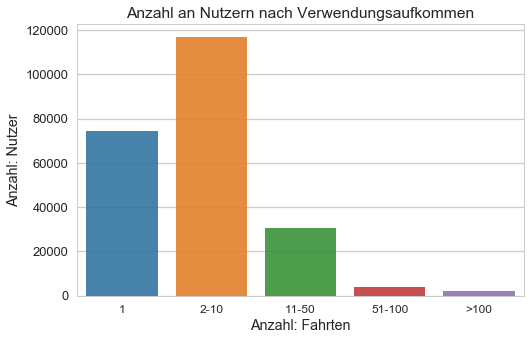

In [40]:
plt.figure(figsize=(8,5))

sns.set_style("whitegrid")
sns.set_context("talk")

index = ['1', '2-10', '11-50', '51-100', '>100']

ax = sns.barplot(aggregated_by_category_series.index, aggregated_by_category_series, alpha=0.9 )

ax.set_xlabel('Anzahl: Fahrten')
ax.set_ylabel('Anzahl: Nutzer')
ax.set_xticklabels(index, rotation='horizontal', fontsize=12)
ax.set_title('Anzahl an Nutzern nach Verwendungsaufkommen')

plt.show()

<u>Das Balkendiagramm zeigt die Verteilung der Nutzer nach Nutzungsverhalten über die Dauer der beiden Jahre</u> 

<hr/>
## Was ist die Auslastung des Systems nach Monat und Jahr?

<i>Eine Kopie der oben bereinigten DataFrames wird erstellt:</i>

In [41]:
df2016_copy = df2016
df2017_copy = df2017

<i>Damit pd.Grouper angewendet werden kann muss der Index ein DateTimeIndex sein:</i>

In [42]:
df2016_copy.index = df2016_copy['Startdatum'] 
df2017_copy.index = df2017_copy['Startdatum']

<i>Die Trips werden zuerst für das Jahr 2016 je Monat gruppiert und aggregiert:</i>

In [43]:
df2016_grouped_month = df2016.groupby(pd.Grouper(freq='M'))

aggregated_by_month_2016_dataframe = df2016_grouped_month.agg(np.size)

aggregated_by_month_2016 = aggregated_by_month_2016_dataframe['Startdatum']

agg_sixteen = aggregated_by_month_2016.to_frame('Anzahl_Fahrten_Monat')

<i>Nun wird das Gleiche für das Jahr 2017 gemacht:</i>

In [44]:
df2017_grouped_month = df2017.groupby(pd.Grouper(freq='M'))

aggregated_by_month_2017_dataframe = df2017_grouped_month.agg(np.size)

aggregated_by_month_2017 = aggregated_by_month_2017_dataframe['Startdatum']

agg_seventeen = aggregated_by_month_2017.to_frame('Anzahl_Fahrten_Monat')

<i>Die beiden DataFrames werden zu Series-Objekten transformiert da einfacher visualisierbar:</i>

In [45]:
agg_sixteen_series    = agg_sixteen['Anzahl_Fahrten_Monat']
agg_seventeen_series  = agg_seventeen['Anzahl_Fahrten_Monat']

<i>Nachdem die transformierten Daten zur Verfügung stehen, werden diese visualisiert:</i>

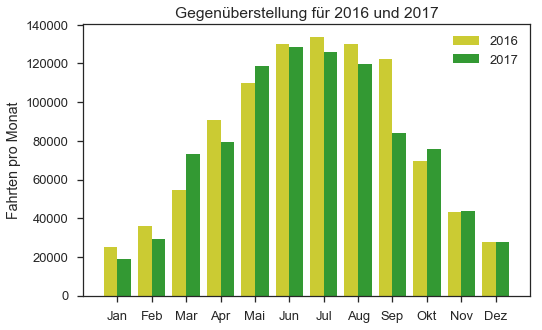

In [46]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8.0
fig_size[1] = 5.0

sns.set_style("ticks")
sns.set_context("talk")

fig, ax = plt.subplots()
index = np.arange(12)
bar_width = 0.4

bars1 = ax.bar(index, agg_sixteen_series, bar_breite, alpha=0.8, color='y')
bars2 = ax.bar(index+bar_breite, agg_seventeen_series, bar_width, alpha=0.8, color='g')

ax.set_xticks(index + bar_breite / 2)
ax.set_title('Gegenüberstellung für 2016 und 2017')
ax.set_xticklabels(('Jan','Feb','Mar','Apr','Mai','Jun','Jul','Aug','Sep','Okt','Nov','Dez'))
ax.set_ylabel('Fahrten pro Monat')
ax.legend((bars1, bars2), ('2016', '2017'))

plt.show()

<hr/>
## Wie korrelieren die Daten miteinander?

In [49]:
df_total_cleansed.corr()

,Anfangsstation_ID,Endstation_ID,Fahrrad_ID,Fahrtpreis,Gebuehr
Anfangsstation_ID,1.000000,0.014017,0.006181,-0.004173,-0.001077
Endstation_ID,0.014017,1.000000,0.005754,-0.059788,-0.420607
Fahrrad_ID,0.006181,0.005754,1.000000,-0.004994,-0.001706
Fahrtpreis,-0.004173,-0.059788,-0.004994,1.000000,0.137930
Gebuehr,-0.001077,-0.420607,-0.001706,0.137930,1.000000


<u>Keine signifikante Korrelation<u/>

<hr/>
## Verteilung der Fahrtdauer